In [1]:
import pandas as pd
import numpy as np
import json
import re 
import sys
import itertools
import cv2
from PIL import Image
from requests import post
import base64

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from skimage import io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import spotipy
import spotipy.oauth2 as oauth2
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util

import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline

In [3]:
#another useful command to make data exploration easier
# NOTE: if you are using a massive dataset, this could slow down your code. 
pd.set_option('display.max_columns', None)
# pd.set_option("max_rows", None)

In [4]:
df = pd.read_csv('Datasets/Datasets/kaggleMusicMoodFinal.csv')

In [5]:
spotify_df = df.copy()

In [6]:
spotify_df.shape

(156410, 27)

In [7]:
float_cols = spotify_df.dtypes[spotify_df.dtypes == 'float64'].index.values

In [8]:
ohe_cols = 'popularity'

In [9]:
# create 5 point buckets for popularity 
spotify_df['bucket_popularity'] = spotify_df['popularity'].apply(lambda x: int(x/5))

In [10]:
spotify_df['consolidates_genre_lists_upd'] = spotify_df['consolidates_genre_lists'].apply(lambda x: [re.sub(' ','_',i) for i in re.findall(r"'([^']*)'", x)])

In [11]:
spotify_df.tail()

Unnamed: 0.1  Unnamed: 0  valence  year  acousticness  \
156405        156575      156575    0.620  1999        0.0826   
156406        156576      156576    0.974  1986        0.2340   
156407        156577      156577    0.546  2003        0.1420   
156408        156578      156578    0.966  1988        0.0431   
156409        156579      156579    0.902  1925        0.9270   

                            artists  danceability  duration_ms  energy  \
156405      ['"Weird Al" Yankovic']         0.618       682947   0.768   
156406      ['"Weird Al" Yankovic']         0.776       230667   0.605   
156407      ['"Weird Al" Yankovic']         0.740       219960   0.492   
156408      ['"Weird Al" Yankovic']         0.826       217387   0.694   
156409  ['"Test for Victor Young"']         0.734       175693   0.474   

        explicit                      id  instrumentalness  key  liveness  \
156405         0  2Ec0liSMY2h4XORHyzKCmY            0.0000   10    0.0907   
156406         0  2zMUYAHJfDU5MKqoCusTwo            0.0000    2    0.1300   
156407         0  1Yd0HypJ0bzilJS9MBztZZ            0.0000    1    0.1150   
156408         0  2CstSu0GDI4dUFtE3VdubW            0.0000    4    0.0975   
156409         0  6ivMXI6YMOPvsiUyTDIV7b            0.0762   10    0.7370   

        loudness  mode                                               name  \
156405    -9.881     1                                        Albuquerque   
156406   -10.489     1                                  Addicted to Spuds   
156407   -10.237     1  A Complicated Song (Parody of "Complicated" by...   
156408   -10.265     1                  (This Song's Just) Six Words Long   
156409   -10.544     1                                     Bugle Call Rag   

        popularity release_date  speechiness    tempo  \
156405          38   1999-06-29       0.3200  186.599   
156406          24   1986-10-21       0.0326  116.009   
156407          39   2003-05-20       0.0597   82.033   
156408          35   1988-01-01       0.0614  150.018   
156409           3         1925       0.2560  132.788   

                     artists_upd_v1             artists_upd_v2  \
156405      ['"Weird Al" Yankovic']               ['Weird Al']   
156406      ['"Weird Al" Yankovic']               ['Weird Al']   
156407      ['"Weird Al" Yankovic']               ['Weird Al']   
156408      ['"Weird Al" Yankovic']               ['Weird Al']   
156409  ['"Test for Victor Young"']  ['Test for Victor Young']   

                        artists_upd  \
156405      ['"Weird Al" Yankovic']   
156406      ['"Weird Al" Yankovic']   
156407      ['"Weird Al" Yankovic']   
156408      ['"Weird Al" Yankovic']   
156409  ['"Test for Victor Young"']   

                                             artists_song  \
156405                     "Weird Al" YankovicAlbuquerque   
156406               "Weird Al" YankovicAddicted to Spuds   
156407  "Weird Al" YankovicA Complicated Song (Parody ...   
156408  "Weird Al" Yankovic(This Song's Just) Six Word...   
156409              "Test for Victor Young"Bugle Call Rag   

                  consolidates_genre_lists       Mood  bucket_popularity  \
156405  ['comic', 'comedy_rock', 'parody']  Energetic                  7   
156406  ['comic', 'comedy_rock', 'parody']      Happy                  4   
156407  ['comic', 'comedy_rock', 'parody']      Happy                  7   
156408  ['comic', 'comedy_rock', 'parody']      Happy                  7   
156409                                  []      Happy                  0   

        consolidates_genre_lists_upd  
156405  [comic, comedy_rock, parody]  
156406  [comic, comedy_rock, parody]  
156407  [comic, comedy_rock, parody]  
156408  [comic, comedy_rock, parody]  
156409                            []

In [12]:
#simple function to create OHE features
#this gets passed later on
def One_Hot_Encode_Prep(df, column, new_name): 
    """ 
    Create One Hot Encoded features of a specific column

    Parameters: 
        df (pandas dataframe): Spotify Dataframe
        column (str): Column to be processed
        new_name (str): new column name to be used
        
    Returns: 
        tf_df: One hot encoded features 
    """
    
    tf_df = pd.get_dummies(df[column])
    feature_names = tf_df.columns
    tf_df.columns = [new_name + "|" + str(i) for i in feature_names]
    tf_df.reset_index(drop = True, inplace = True)    
    return tf_df



#function to build entire feature set
def Feature_Set_Using_TDiDF(df, float_cols):
    """ 
    Process spotify df to create a final set of features that will be used to generate recommendations

    Parameters: 
        df (pandas dataframe): Spotify Dataframe
        float_cols (list(str)): List of float columns that will be scaled 
        
    Returns: 
        final: final set of features 
    """
    
    #tfidf genre lists
    tfidf = TfidfVectorizer()
    tfidf_matrix =  tfidf.fit_transform(df['consolidates_genre_lists_upd'].apply(lambda x: " ".join(x)))
    genre_df = pd.DataFrame(tfidf_matrix.toarray())
    genre_df.columns = ['genre' + "|" + i for i in tfidf.get_feature_names_out()]
    genre_df.reset_index(drop = True, inplace=True)

    #explicity_ohe = One_Hot_Encode_Prep(df, 'explicit','exp')    
    year_ohe = One_Hot_Encode_Prep(df, 'year','year') * 0.5
    popularity_ohe = One_Hot_Encode_Prep(df, 'bucket_popularity','pop') * 0.15

    #scale float columns
    floats = df[float_cols].reset_index(drop = True)
    scaler = MinMaxScaler()
    floats_scaled = pd.DataFrame(scaler.fit_transform(floats), columns = floats.columns) * 0.2

    #concanenate all features
    final = pd.concat([genre_df, floats_scaled, popularity_ohe, year_ohe], axis = 1)
     
    #add song id
    final['id']=df['id'].values
    
    return final


def Get_Spotify_Playlist_DataFrame(playlist_name,id_dic, df):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        playlist_name (str): name of the playlist you'd like to pull from the spotify API
        id_dic (dic): dictionary that maps playlist_name to playlist_id
        df (pandas dataframe): spotify datafram
        
    Returns: 
        playlist: all songs in the playlist THAT ARE AVAILABLE IN THE KAGGLE DATASET
    """
    
    #generate playlist dataframe
    playlist = pd.DataFrame()
    playlist_name = playlist_name
    
    #print(len(sp.playlist(id_dic[playlist_name])['tracks']['items']))

    for ix, i in enumerate(sp.playlist(id_dic[playlist_name])['tracks']['items']):
        #print(i['track']['artists'][0]['name'])
        playlist.loc[ix, 'artist'] = i['track']['artists'][0]['name']
        playlist.loc[ix, 'name'] = i['track']['name']
        playlist.loc[ix, 'id'] = i['track']['id'] # ['uri'].split(':')[2]
        playlist.loc[ix, 'url'] = i['track']['album']['images'][1]['url']
        playlist.loc[ix, 'date_added'] = i['added_at']

    playlist['date_added'] = pd.to_datetime(playlist['date_added'])  
    
    # playlist = playlist[playlist['id'].isin(df['id'].values)].sort_values('date_added',ascending = False)
    
    return playlist




def visualize_songs(df):
    """ 
    Visualize cover art of the songs in the inputted dataframe

    Parameters: 
        df (pandas dataframe): Playlist Dataframe
    """
    
    temp = df['url'].values
    plt.figure(figsize=(15,int(0.625 * len(temp))))
    columns = 5
    
    for i, url in enumerate(temp):
        plt.subplot(int(len(temp) / columns + 1), columns, i + 1)

        image = io.imread(url)
        plt.imshow(image)
        plt.xticks(color = 'w', fontsize = 0.1)
        plt.yticks(color = 'w', fontsize = 0.1)
        plt.xlabel(df['name'].values[i], fontsize = 12)
        plt.tight_layout(h_pad=0.4, w_pad=0)
        plt.subplots_adjust(wspace=None, hspace=None)

    plt.show()
    
    
    

def generate_playlist_feature(complete_feature_set, playlist_df, weight_factor):
    """ 
    Summarize a user's playlist into a single vector

    Parameters: 
        complete_feature_set (pandas data00frame): Dataframe which includes all of the features for the spotify songs
        playlist_df (pandas dataframe): playlist dataframe
        weight_factor (float): float value that represents the recency bias. The larger the recency bias, the most priority recent songs get. Value should be close to 1. 
        
    Returns: 
        playlist_feature_set_weighted_final (pandas series): single feature that summarizes the playlist
        playlist_features_not_in_dataframe (pandas dataframe): 
    """
    
    playlist_features_in_dataframe = complete_feature_set[complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1).mean(axis =0)
    playlist_features_in_dataframe = playlist_features_in_dataframe.merge(playlist_df[['id','date_added']], on = 'id', how = 'inner')
    playlist_features_not_in_dataframe = complete_feature_set[~complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1)
    
    playlist_feature_set = playlist_features_in_dataframe.sort_values('date_added',ascending=False)

    most_recent_date = playlist_feature_set.iloc[0,-1]
    
    for ix, row in playlist_feature_set.iterrows():
        playlist_feature_set.loc[ix,'months_from_recent'] = int((most_recent_date.to_pydatetime() - row.iloc[-1].to_pydatetime()).days / 30)
        
    playlist_feature_set['weight'] = playlist_feature_set['months_from_recent'].apply(lambda x: weight_factor ** (-x))
    
    playlist_feature_set_weighted = playlist_feature_set.copy()
    #print(playlist_feature_set_weighted.iloc[:,:-4].columns)
    playlist_feature_set_weighted.update(playlist_feature_set_weighted.iloc[:,:-4].mul(playlist_feature_set_weighted.weight,0))
    playlist_feature_set_weighted_final = playlist_feature_set_weighted.iloc[:, :-4]
    #playlist_feature_set_weighted_final['id'] = playlist_feature_set['id']
    
    return playlist_feature_set_weighted_final.sum(axis = 0), playlist_features_not_in_dataframe





def Recommend_Playlist(df, features, nonplaylist_features):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        df (pandas dataframe): spotify dataframe
        features (pandas series): summarized playlist feature
        nonplaylist_features (pandas dataframe): feature set of songs that are not in the selected playlist
        
    Returns: 
        non_playlist_df_top_40: Top 40 recommendations for that playlist
    """
    
    non_playlist_df = df[df['id'].isin(nonplaylist_features['id'].values)]
    non_playlist_df['sim'] = cosine_similarity(nonplaylist_features.drop('id', axis = 1).values, features.values.reshape(1, -1))[:,0]
    non_playlist_df_top_40 = non_playlist_df.sort_values('sim',ascending = False).head(40)
    non_playlist_df_top_40['url'] = non_playlist_df_top_40['id'].apply(lambda x: sp.track(x)['album']['images'][1]['url'])
    
    return non_playlist_df_top_40



In [13]:
CLIENT_ID = '40e1db49745b404c8550796e5028d9e3'
CLIENT_SECRET = '5c6bd8532ccf4f629cf5fd9030594012'
REDIRECT_URI = "http://localhost:8888/"

In [14]:
credentials = oauth2.SpotifyClientCredentials(
        client_id=CLIENT_ID,
        client_secret=CLIENT_SECRET)

In [15]:
scope = 'user-library-read playlist-read-private'

if len(sys.argv) > 1:
    username = sys.argv[1]
else:
    print("Usage: %s username" % (sys.argv[0],))
    sys.exit()

In [16]:
auth_manager = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [17]:
token = util.prompt_for_user_token(scope, client_id=CLIENT_ID, client_secret=CLIENT_SECRET, redirect_uri='http://127.0.0.1:3001')

In [18]:
# token = credentials.get_access_token()
# print(token)

In [19]:
# def get_token():
#     auth_string = client_id + ":" + client_secret
#     auth_bytes = auth_string.encode("utf8")
#     auth_base64 = str(base64.b64encode(auth_bytes), "utf-8")

#     url = "https://accounts.spotify.com/api/token"
#     headers = {
#         "Authorization": "Basic "+ auth_base64,
#         "Content-Type": "application/x-www-form-urlencoded"
#     }

#     data = {"grant_type":"client_credentials"}
#     result = post(url ,headers = headers, data = data)
#     json_result = json.loads(result.content)
#     token = json_result['access_token']
#     return token

In [20]:
# token = get_token()
# print(token)
# token = token['access_token']

In [21]:
# def get_auth_header(token):
#     return {"Authorization": f"Bearer {token}"}
    


In [22]:
# print(get_auth_header(token))

In [23]:
print(token)

BQAAw00m7K8GvcSl63IeFL7P-8uLy7xpRkPMoMYvnJfB_4jKeEqsFWaK-3ED_zxe2mRQ8NgKNbXc718G9_XQ1inPM7okOWW_ITBoSIqzUgsrbxD-5l5vdt_TjSa0QGCh0mTiWfSXHjl4wix0RsIPTphxlcmMdtlmKDfk6cmS9TNRiJbD0cXDesM1l5y661HWh2yhogigE_vwyEPgJWwL-fHg6iFhmowzzb9hvDbdbygcUHN-abVaVt3OstyhxEpuFkOQZoN5DcVKU2DHVisvutQgzH4


In [24]:
sp = spotipy.Spotify(token)
print(sp)

In [37]:
# gather playlist names and images. 
# images aren't going to be used until I start building a UI
id_name = {}
list_photo = {}
for i in sp.current_user_playlists()['items']:
    # print(sp.current_user_playlists()['items'])
    id_name[i['name']] = i['uri'].split(':')[2]
    if i['images']:  # Check if the images list is not empty
        list_photo[i['uri'].split(':')[2]] = i['images'][0]['url']
    else:
        # Handle the case when there are no images for the playlist
        list_photo[i['uri'].split(':')[2]] = "No image available"

In [26]:
id_name

{'lofi covers': '37i9dQZF1DX4nNmLlb3JR2',
 'Top 100 Most Viewed English Songs of All Time - Most Popular English Music Artist Playlist': '0QN2m4k1Mwgv6XO2UoVuNn',
 'Anime Lofi Playlist (for chill, study, sleep)': '1QcsybeUidDJIrPQTHS6dD',
 'Manga & Anime Lullaby': '4iYssl8gMfORuHLbDocDcV',
 'Bollywood Central': '37i9dQZF1DWXtlo6ENS92N',
 'My Playlist #3': '6e27VJXLahoYXi0JO5HFtU',
 'My Playlist #2': '4GRUIdRcSscH8rq6Zk3OhI',
 '24/7': '1mDOHzGT9Hc7ECiOftnDi6',
 'नेपाली ब्र!': '5VDU07nxTy1174RSGdLmc1',
 'My Playlist #1': '5jP0Mf20G4I7rT162R3D7s'}

In [27]:
# def ChooseDataset(x):
#     if x == "Disgust":
#         return spotify_df[spotify_df['Mood'].isin(['Energetic', 'Happy', 'Calm'])]
#     if x == "Angry":
#         return spotify_df[spotify_df['Mood'].isin(['Energetic', 'Calm'])]
#     if x == "Fear":
#         return spotify_df[spotify_df['Mood'].isin(['Happy', 'Calm'])]
#     if x == "Happy":
#         return spotify_df[spotify_df['Mood'].isin(['Happy', 'Calm'])]
#     if x == "Sad":
#         return spotify_df[spotify_df['Mood'].isin(['Sad', 'Happy', 'Calm'])]
#     if x == "Surprise":
#         return spotify_df[spotify_df['Mood'].isin(['Energetic', 'Happy', 'Sad'])]
#     return spotify_df

In [28]:
def ChooseDataset(x):
    if x == "Disgust":
        return spotify_df[spotify_df['Mood'].isin(['Energetic', 'Calm'])]
    if x == "Angry":
        return spotify_df[spotify_df['Mood'].isin(['Energetic', 'Calm'])]
    if x == "Fear":
        return spotify_df[spotify_df['Mood'].isin(['Happy', 'Calm'])]
    if x == "Happy":
        return spotify_df[spotify_df['Mood'].isin(['Happy', 'Calm'])]
    if x == "Sad":
        return spotify_df[spotify_df['Mood'].isin(['Sad'])]
    if x == "Surprise":
        return spotify_df[spotify_df['Mood'].isin(['Energetic', 'Happy', 'Sad'])]
    return spotify_df

In [29]:
from tensorflow.keras.models import load_model
model = load_model('facialemotionmodel.h5', compile = True)

In [46]:
def Recommend_Top40(x):
    #..............................
    #.............................
    #............................
    
    O_df = ChooseDataset(x)
    # Feature Engineering from main dataframe
    complete_feature_set = Feature_Set_Using_TDiDF(O_df, float_cols=float_cols)#.mean(axis = 0)
    
    # collecting spotify user playlist dataframe
    one_playlist_from_spotify = Get_Spotify_Playlist_DataFrame('Top 100 Most Viewed English Songs of All Time - Most Popular English Music Artist Playlist', id_name, O_df)
    # one_playlist_from_spotify = Get_Spotify_Playlist_DataFrame('EDM', O_df)
    
    
    # linear vector for recommendation
    features_in_the_playlist, features_not_in_the_playlist = generate_playlist_feature(complete_feature_set, one_playlist_from_spotify, 1.09)
    
    
    # Recommended Songs store here
    top40_recommendation = Recommend_Playlist(spotify_df, features_in_the_playlist, features_not_in_the_playlist)
    
    
    visualize_songs(top40_recommendation)
    
    
    

In [39]:
def moodNamePrintFromLabel(n):
    if n == 0: result = "Angry"
    elif n == 1: result = "Disgust"
    elif n == 2: result = "Fear"
    elif n == 3: result = "Happy"
    elif n == 4: result = "Sad"
    elif n == 5: result = "Surprise"
    elif n == 6: result = "Neutral"
        
    return result

def imageToMoodDetection(img_path):

    img = cv2.imread(img_path)

    Gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    haar_file=cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
    face_cascade=cv2.CascadeClassifier(haar_file)
    
    faces = face_cascade.detectMultiScale(Gray_img, 1.3, 3)

    for (x,y,w,h) in faces:
      pxl_lst = []
      for i in range(y, y+h):
        lst = []
        for j in range(x, x+w):
          lst.append(Gray_img[i][j])
        pxl_lst.append(lst)
      single_face = np.array(pxl_lst)
      single_face = np.reshape(single_face,(h,w,))

      resized_img = cv2.resize(single_face, (48,48), interpolation = cv2.INTER_AREA)
      
      resized_img = np.reshape(resized_img,(1,48,48,1))/255.0

      #passing to model
      result = np.argmax(loaded_model.predict(resized_img), axis=-1)
      if result is not None:
        print(moodNamePrintFromLabel(result))

In [40]:
def plot_image(image_path):
    # Load the image
    img = mpimg.imread(image_path)

    # Plot the image
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')  # Turn off axis labels
    plt.show()

In [41]:
Image_path = 'images/test/fear/10029.jpg'

In [42]:
# imageToMoodDetection('Image_path')

In [43]:
# plot_image(Image_path)

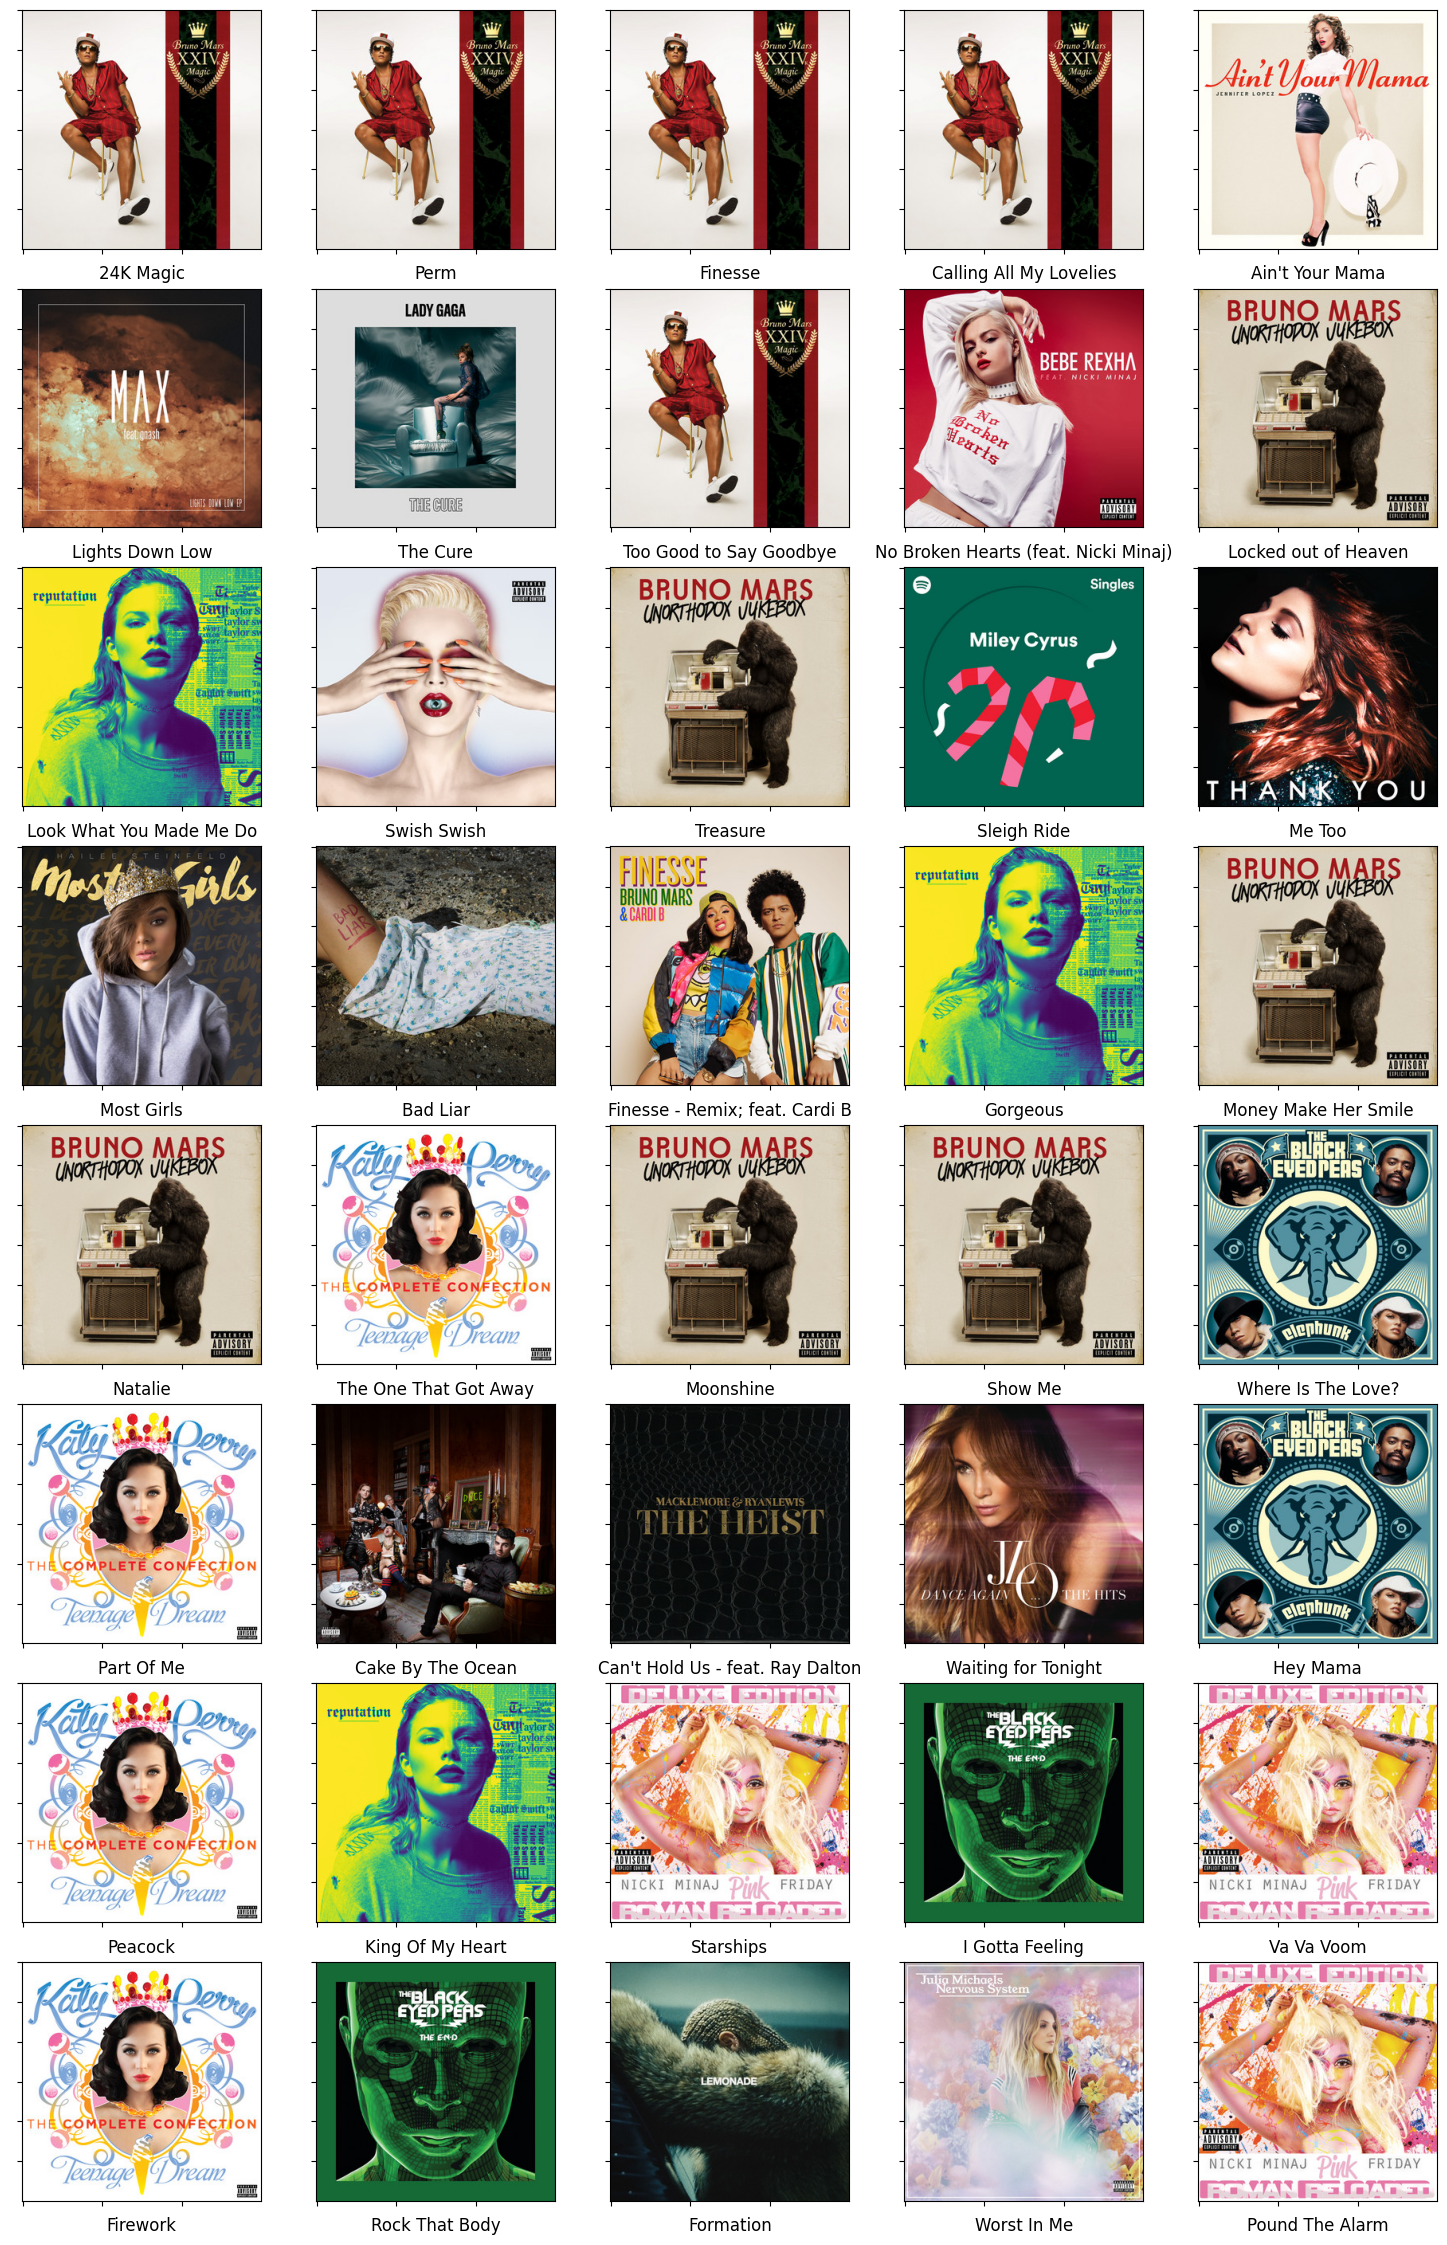

In [47]:
Recommend_Top40('Happy')